# Machine Learning Engineer Nanodegree

## Capstone Project

## Project: Machine Learning Model for Distracted Driver Detection 

---

---

### The Road Ahead

The notebook is broken into separate steps as shown below.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Create a CNN to Classify Driver Images (from Scratch)
* [Step 2](#step2): Train a CNN with Transfer Learning - Part1 (Using the bottleneck features)
* [Step 3](#step3): Train a CNN with Transfer Learning - Part2 (Using Fine-tuning)

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Driver Dataset

In the code cell below, we import a dataset of driver images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split

# define function to load datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 10)
    return files, targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('images/train')
test_files, test_targets = load_dataset('images/test')
#valid_files, valid_targets = load_dataset('dogImages/valid')


# load list of names
names = [item[17:19] for item in sorted(glob("images/train/*/"))]

# break training set into training and validation sets
#(train_files, valid_files) = train_files[:18000], train_files[18000:]
#(train_targets, valid_targets) = train_targets[:18000], train_targets[18000:]
train_files, valid_files, train_targets, valid_targets = train_test_split(train_files, train_targets, test_size=0.2, random_state=42)

# print statistics about the dataset

print('There are %s total images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training images.' % len(train_files))
print('There are %d total training categories.' % len(names))
print('There are %d validation images.' % len(valid_files))
print('There are %d test images.'% len(test_files))

There are 150 total images.

There are 80 training images.
There are 10 total training categories.
There are 20 validation images.
There are 50 test images.


### Dataset Exploration

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("driver_imgs_list.csv",header='infer')
print(df['classname'].head(3))
print(df.iloc[:,1].describe())
print("\n Image Counts")
print(df['classname'].value_counts(sort=False))

0    c0
1    c0
2    c0
Name: classname, dtype: object
count     22424
unique       10
top          c0
freq       2489
Name: classname, dtype: object

 Image Counts
c1    2267
c2    2317
c9    2129
c8    1911
c0    2489
c5    2312
c3    2346
c7    2002
c4    2326
c6    2325
Name: classname, dtype: int64


### Dataset Visualization

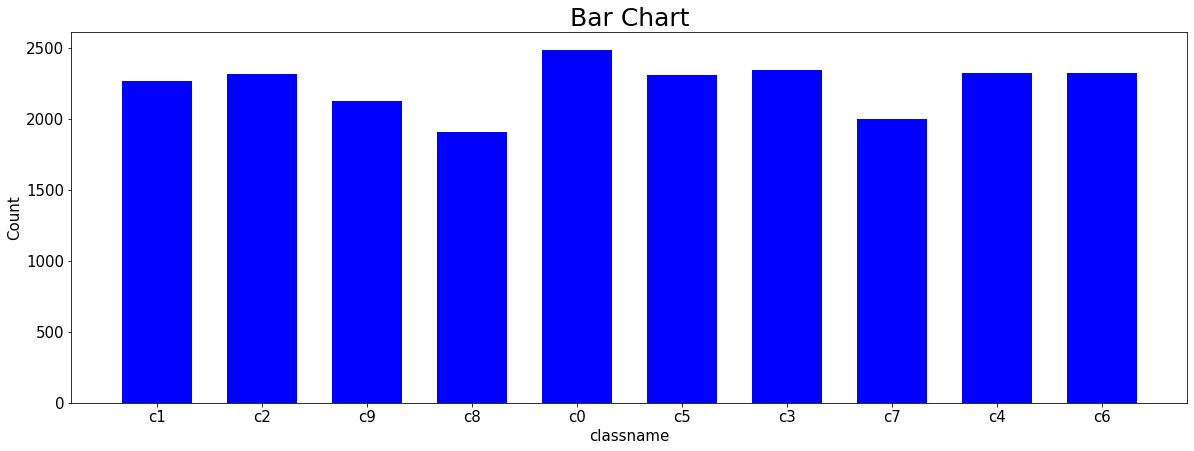

In [4]:
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

nf = df['classname'].value_counts(sort=False)
labels = df['classname'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [5]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

---
<a id='step1'></a>
## Step 1: Create a CNN to Classify Driver Images (from Scratch)



### Pre-process the Data

The images are rescaled by dividing every pixel in every image by 255. 0.5 is subtracted to ensure the mean is zero.

In [6]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255 - 0.5
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255 - 0.5
test_tensors = paths_to_tensor(test_files).astype('float32')/255 - 0.5

100%|██████████| 50/50 [00:00<00:00, 367.19it/s]


### (IMPLEMENTATION) Model Architecture

A CNN is created to classify driver images.  At the end of the code cell block, the layers of the model are summarized by executing the line:
    
        model.summary()

We have created 4 convolutional layers with 4 max pooling layers in between. Filters were increased from 64 to 512 in each of the convolutional layers. Also dropout was used along with flattening layer before using the fully connected layer. Number of nodes in the last fully connected layer were setup as 10 along with softmax activation function. Relu activation function was used for all other layers.Xavier initialization was used in each of the layers.

4 convolutional layers were used to learn hierarchy of high level features. Max pooling layer is added to reduce the dimensionality. Flatten layer is added to reduce the matrix to row vector. This is because fully connected layer only accepts row vector. Dropout layers were added to reduce overfitting and ensure that the network generalizes well. The last fully connected layer with softmax activation function is added to obtain probabilities of the prediction.

In [7]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))


model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       131328    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 256)       0         
______________________________________

### Compile the Model

In [8]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

The model is trained in the code cell below. Model checkpointing is used to save the model that attains the best validation loss.

Augmentation i.e. [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), can also be used as per the need. 

In [9]:
from keras.callbacks import ModelCheckpoint  

epochs = 30 # epochs used is 30 and batch size is 40

checkpointer = ModelCheckpoint(filepath='weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=40, callbacks=[checkpointer], verbose=1)


Train on 80 samples, validate on 20 samples
Epoch 1/30
80/80 [==============================] - 13s 168ms/step - loss: 15.1965 - accuracy: 0.1250 - val_loss: 3.0012 - val_accuracy: 0.0500

Epoch 00001: val_loss improved from inf to 3.00116, saving model to weights.best.from_scratch.hdf5
Epoch 2/30
80/80 [==============================] - 12s 155ms/step - loss: 2.6886 - accuracy: 0.1250 - val_loss: 2.3147 - val_accuracy: 0.0500

Epoch 00002: val_loss improved from 3.00116 to 2.31468, saving model to weights.best.from_scratch.hdf5
Epoch 3/30
80/80 [==============================] - 18s 219ms/step - loss: 2.3142 - accuracy: 0.1000 - val_loss: 2.2969 - val_accuracy: 0.0500

Epoch 00003: val_loss improved from 2.31468 to 2.29685, saving model to weights.best.from_scratch.hdf5
Epoch 4/30
80/80 [==============================] - 13s 165ms/step - loss: 2.3529 - accuracy: 0.1125 - val_loss: 2.3340 - val_accuracy: 0.0500

Epoch 00004: val_loss did not improve from 2.29685
Epoch 5/30
80/80 [====

### Load the Model with the Best Validation Loss

In [10]:
model.load_weights('weights.best.from_scratch.hdf5')

In [11]:
test_files_final = [item_test[15:] for item_test in test_files]

### Test the Model

The model is tried on the test dataset of driver images.

In [12]:
predictions = [model.predict(np.expand_dims(tensor, axis=0))[0] for tensor in test_tensors]

In [13]:
subm = np.column_stack((np.asarray(test_files_final), np.asarray(predictions,dtype=np.float32)))

In [15]:
print(subm[1:4])

[['t/img_20357.jpg' '0.027232496' '0.083712384' '0.33201015' '0.09262748'
  '0.026723994' '0.016407846' '0.31632018' '0.0068669035' '0.033907004'
  '0.06419161']
 ['t/img_20356.jpg' '0.09524828' '0.15722592' '0.1372237' '0.18128169'
  '0.06398636' '0.012606534' '0.08220812' '0.05985189' '0.15875508'
  '0.0516124']
 ['t/img_47488.jpg' '0.0013499353' '0.0021703807' '0.008874771'
  '0.047901012' '0.03978037' '0.8900887' '0.0015866857' '0.005180446'
  '0.00035804746' '0.00270958']]


In [20]:
print(subm[1:6])

[['t/img_20357.jpg' '0.027232496' '0.083712384' '0.33201015' '0.09262748'
  '0.026723994' '0.016407846' '0.31632018' '0.0068669035' '0.033907004'
  '0.06419161']
 ['t/img_20356.jpg' '0.09524828' '0.15722592' '0.1372237' '0.18128169'
  '0.06398636' '0.012606534' '0.08220812' '0.05985189' '0.15875508'
  '0.0516124']
 ['t/img_47488.jpg' '0.0013499353' '0.0021703807' '0.008874771'
  '0.047901012' '0.03978037' '0.8900887' '0.0015866857' '0.005180446'
  '0.00035804746' '0.00270958']
 ['t/img_12.jpg' '0.05929871' '0.069039166' '0.023994142' '0.037922535'
  '0.13494915' '0.048393004' '0.1498171' '0.4398979' '0.029175928'
  '0.0075123594']
 ['t/img_35294.jpg' '0.0026175962' '0.12725244' '0.1665128' '0.030762391'
  '0.009590377' '0.008203086' '0.08893084' '0.009380303' '0.43914044'
  '0.1176097']]


In [13]:
from IPython.display import FileLink
FileLink('kaggle_submissions/submission.csv')

/code/home/aind2/capstone/kaggle_submissions/submission.csv

The submission resulted in Public Score of 2.67118. This can result in rank of 1362 out of 1440 in Public Leaderboard i.e. in top 94.58%

---
<a id='step2'></a>
## Step 2: Train a CNN with Transfer Learning - Part1

To reduce training time without sacrificing accuracy, a CNN is trained using transfer learning.  

### Using the bottleneck features of a pre-trained network

---

### Obtain Bottleneck Features

In [21]:
from keras.applications.vgg16 import VGG16
model = VGG16(include_top=False)
model.summary()

58892288/58889256 [==============================] - 43s 1us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_____________________________________________________________

In [24]:
bottleneck_features_train_VGG16 = np.asarray([model.predict(np.expand_dims(tensor, axis=0))[0] for tensor in train_tensors],dtype=np.float32)
#bottleneck_features_train_VGG16 = model.predict_generator(generator, nb_train_samples // batch_size)
np.save(open('bottleneck_features/bottleneck_features_train_VGG16.npy', 'wb'),bottleneck_features_train_VGG16)


bottleneck_features_valid_VGG16 = np.asarray([model.predict(np.expand_dims(tensor, axis=0))[0] for tensor in valid_tensors],dtype=np.float32)
#bottleneck_features_train_VGG16 = model.predict_generator(generator, nb_train_samples // batch_size)
np.save(open('bottleneck_features/bottleneck_features_valid_VGG16.npy', 'wb'),bottleneck_features_valid_VGG16)


bottleneck_features_test_VGG16 = np.asarray([model.predict(np.expand_dims(tensor, axis=0))[0] for tensor in test_tensors],dtype=np.float32)
np.save(open('bottleneck_features/bottleneck_features_test_VGG16.npy', 'wb'),bottleneck_features_test_VGG16)

In [28]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [17]:
print(bottleneck_features_train_VGG16.shape)
print(bottleneck_features_valid_VGG16.shape)
print(bottleneck_features_test_VGG16.shape)

(17939, 7, 7, 512)
(4485, 7, 7, 512)
(79726, 7, 7, 512)


### Model Architecture1

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each driver category and is equipped with a softmax.

In [21]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=bottleneck_features_train_VGG16.shape[1:]))
VGG16_model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 5,130
Trainable params: 5,130
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [22]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [23]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5_transfer_learning', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(bottleneck_features_train_VGG16, train_targets, 
          validation_data=(bottleneck_features_valid_VGG16, valid_targets),
          epochs=400, batch_size=16, callbacks=[checkpointer], verbose=1)

Train on 17939 samples, validate on 4485 samples
Epoch 1/400
17939/17939 [==============================] - 7s - loss: 2.0640 - acc: 0.3635 - val_loss: 1.8389 - val_acc: 0.4916
Epoch 2/400
17939/17939 [==============================] - 6s - loss: 1.6718 - acc: 0.5994 - val_loss: 1.5223 - val_acc: 0.6553
Epoch 3/400
17939/17939 [==============================] - 6s - loss: 1.4050 - acc: 0.7011 - val_loss: 1.3083 - val_acc: 0.7041
Epoch 4/400
17939/17939 [==============================] - 6s - loss: 1.2105 - acc: 0.7553 - val_loss: 1.1383 - val_acc: 0.7670
Epoch 5/400
17939/17939 [==============================] - 7s - loss: 1.0649 - acc: 0.7950 - val_loss: 1.0029 - val_acc: 0.8107
Epoch 6/400
17939/17939 [==============================] - 6s - loss: 0.9485 - acc: 0.8183 - val_loss: 0.8971 - val_acc: 0.8348
Epoch 7/400
17939/17939 [==============================] - 7s - loss: 0.8543 - acc: 0.8403 - val_loss: 0.8122 - val_acc: 0.8508
Epoch 8/400
17939/17939 [==============================

### Load the Model with the Best Validation Loss

In [24]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5_transfer_learning')

### Test the Model

The model is tried on the test dataset of driver images.

In [25]:
# get index of predicted dog breed for each image in test set
#VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

VGG16_predictions = [VGG16_model.predict(np.expand_dims(tensor, axis=0))[0] for tensor in bottleneck_features_test_VGG16]

# report test accuracy
#test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
#print('Test accuracy: %.4f%%' % test_accuracy)

In [26]:
VGG16_subm = np.column_stack((np.asarray(test_files_final), np.asarray(VGG16_predictions,dtype=np.float32)))

---
### Model Architecture2

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We have added a Flatten layer and two fully connected layers.The last fully connected layer contains one node for each driver category and is equipped with a softmax.

In [5]:
bottleneck_features_train2_VGG16 = np.load('bottleneck_features/bottleneck_features_train_VGG16.npy')
bottleneck_features_valid2_VGG16 = np.load('bottleneck_features/bottleneck_features_valid_VGG16.npy')
bottleneck_features_test2_VGG16 = np.load('bottleneck_features/bottleneck_features_test_VGG16.npy')

In [8]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

VGG16_model2 = Sequential()
VGG16_model2.add(Flatten(input_shape=bottleneck_features_train2_VGG16.shape[1:]))
VGG16_model2.add(Dense(500, activation='relu',kernel_initializer='glorot_normal'))
VGG16_model2.add(Dropout(0.5))
VGG16_model2.add(Dense(10, activation='softmax',kernel_initializer='glorot_normal'))

VGG16_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               12544500  
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5010      
Total params: 12,549,510
Trainable params: 12,549,510
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [11]:
VGG16_model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [33]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5_transfer_learning2', 
                               verbose=1, save_best_only=True)

VGG16_model2.fit(bottleneck_features_train2_VGG16, train_targets, 
          validation_data=(bottleneck_features_valid2_VGG16, valid_targets),
          epochs=400, batch_size=16, callbacks=[checkpointer], verbose=1)

Train on 17939 samples, validate on 4485 samples
Epoch 1/400
17939/17939 [==============================] - 21s - loss: 3.3054 - acc: 0.6021 - val_loss: 0.0753 - val_acc: 0.9775
Epoch 2/400
17939/17939 [==============================] - 21s - loss: 0.3769 - acc: 0.8922 - val_loss: 0.0879 - val_acc: 0.9784
Epoch 3/400
17939/17939 [==============================] - 21s - loss: 0.2845 - acc: 0.9284 - val_loss: 0.1422 - val_acc: 0.9625
Epoch 4/400
17939/17939 [==============================] - 21s - loss: 0.2574 - acc: 0.9436 - val_loss: 0.0461 - val_acc: 0.9931
Epoch 5/400
17939/17939 [==============================] - 21s - loss: 0.2277 - acc: 0.9512 - val_loss: 0.0968 - val_acc: 0.9826
Epoch 6/400
17939/17939 [==============================] - 21s - loss: 0.2004 - acc: 0.9587 - val_loss: 0.0388 - val_acc: 0.9938
Epoch 7/400
17939/17939 [==============================] - 21s - loss: 0.1970 - acc: 0.9619 - val_loss: 0.0318 - val_acc: 0.9949
Epoch 8/400
17939/17939 [=======================

### Load the Model with the Best Validation Loss

In [12]:
VGG16_model2.load_weights('saved_models/weights.best.VGG16.hdf5_transfer_learning2')

### Test the Model

The model is tried on the test dataset of driver images.

In [13]:
VGG16_predictions2 = [VGG16_model2.predict(np.expand_dims(tensor, axis=0))[0] for tensor in bottleneck_features_test2_VGG16]


In [16]:
VGG16_subm2 = np.column_stack((np.asarray(test_files_final), np.asarray(VGG16_predictions2,dtype=np.float32)))

---
<a id='step3'></a>
## Step 3: Train a CNN with Transfer Learning - Part2

To improve accuracy, a CNN is trained using transfer learning.  

### Fine-tuning the top layers of a a pre-trained network

---
### Instantiating the VGG16 base for Fine Tuning

In [7]:
from keras.applications.vgg16 import VGG16
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense

from keras.applications.vgg16 import VGG16
base_model = VGG16(include_top=False)
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### Model Architecture

The model uses the the pre-trained VGG-16 model, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each driver category and is equipped with a softmax.

In [8]:
VGG16_top_model = Sequential()
VGG16_top_model.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:]))
VGG16_top_model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))


VGG16_top_model.load_weights('saved_models/weights.best.VGG16.hdf5_transfer_learning')

model = Model(input= base_model.input, output= VGG16_top_model(base_model.output))

VGG16_top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 5,130
Trainable params: 5,130
Non-trainable params: 0
_________________________________________________________________


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  


### Compile the Model

Upto 15 layers of the VGG16 model were frozen so that the last convolutional block and the fully connected layer which is added to the top can be fine-tuned

In [9]:
# set the first 15 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:15]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='categorical_crossentropy',optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Train the Model

Fine-tuning is done with a very slow learning rate, and typically with the SGD optimizer rather than an adaptative learning rate optimizer such as RMSProp. This is to make sure that the magnitude of the updates stays very small, so as not to wreck the previously learned features.

In [26]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='weights.best.VGG16.hdf5_fine_tuning', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=10, batch_size=16, callbacks=[checkpointer], verbose=1)

Train on 80 samples, validate on 20 samples
Epoch 1/10
80/80 [==============================] - 16s 197ms/step - loss: 0.0706 - accuracy: 0.9750 - val_loss: 3.5052 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 3.50520, saving model to weights.best.VGG16.hdf5_fine_tuning
Epoch 2/10
80/80 [==============================] - 22s 279ms/step - loss: 0.1590 - accuracy: 0.9625 - val_loss: 7.7819 - val_accuracy: 0.3000

Epoch 00002: val_loss did not improve from 3.50520
Epoch 3/10
80/80 [==============================] - 16s 204ms/step - loss: 0.5587 - accuracy: 0.8500 - val_loss: 2.8033 - val_accuracy: 0.4000

Epoch 00003: val_loss improved from 3.50520 to 2.80328, saving model to weights.best.VGG16.hdf5_fine_tuning
Epoch 4/10
80/80 [==============================] - 15s 184ms/step - loss: 0.1547 - accuracy: 0.9375 - val_loss: 2.4680 - val_accuracy: 0.5000

Epoch 00004: val_loss improved from 2.80328 to 2.46804, saving model to weights.best.VGG16.hdf5_fine_tuning
Epoch 5/1

### Load the Model with the Best Validation Loss

In [27]:
model.load_weights('weights.best.VGG16.hdf5_fine_tuning')

### Test the Model

The model is tried on the test dataset of driver images.

In [28]:
VGG16_predictions_fine_tuned = [model.predict(np.expand_dims(tensor, axis=0))[0] for tensor in test_tensors]



In [29]:
VGG16_subm_fine_tuned = np.column_stack((np.asarray(test_files_final), np.asarray(VGG16_predictions_fine_tuned,dtype=np.float32)))


NameError: name 'test_files_final' is not defined